
# AV visual perception


In [1]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# run on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device {device}')
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

plt.rcParams["savefig.bbox"] = 'tight'

# utility function to show images

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Using device cuda


#### Visualizing a grid of images


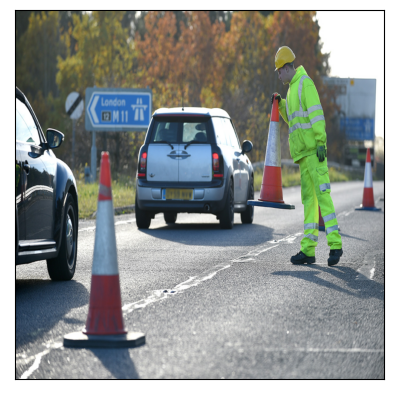

In [2]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import glob

images_names = glob.glob('test/*.jpg')[:1]
images_list = [read_image(img)[: , : , :] for img in images_names]
images_list = [F.resize(img, size=(1000, 1000)) for img in images_list]


grid = make_grid(images_list)
show(grid)

### YOLO v8 model Object detection


image 1/1 /home/o/Desktop/carla/PythonAPI -0.9.9/work/test/High-Speed-Traffic-Management.jpg: 448x640 1 person, 2 cars, 87.4ms
Speed: 4.0ms preprocess, 87.4ms inference, 13.9ms postprocess per image at shape (1, 3, 448, 640)


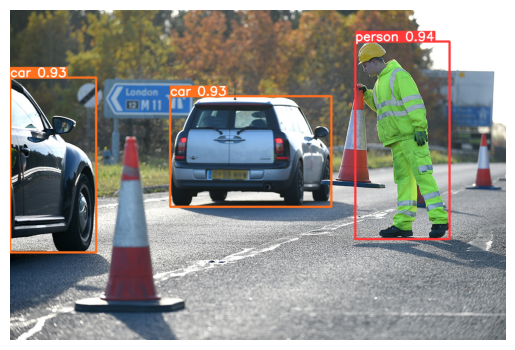

In [3]:
from ultralytics import YOLO
import cv2 
import matplotlib.pyplot as plt

# Load a model
model = YOLO('yolov8x.pt')  # load an official model

# cerate a subplots 
fig, axs = plt.subplots(ncols=len(images_names), squeeze=False)
# Predict with the model
for i, img in enumerate(images_names):
    results = model.predict(img, conf=0.5)[0].plot()
    cv2.imwrite(f'results/{i}.jpg', results)
    axs[0, i].axis("off")
    axs[0, i].imshow(cv2.cvtColor(results, cv2.COLOR_BGR2RGB))

#### bounding boxes produced by torchvision detection models

Here is a Faster R-CNN model loaded from
: `torchvision.models.detection.fasterrcnn_resnet50_fpn`
model.



In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(image) for image in images_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)

We will only plot the boxes with a score greater than a given threshold.



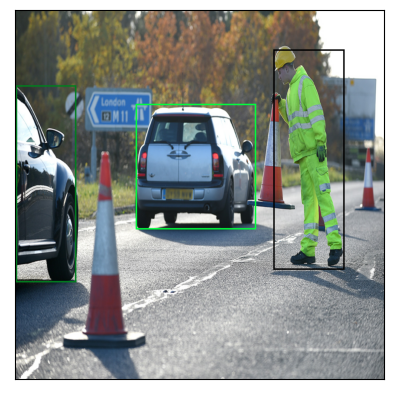

In [5]:
score_threshold = .5
img_with_boxes = [
    draw_bounding_boxes(img, boxes=output['boxes'][output['scores'] > score_threshold] , width=4)
    for img, output  in zip(images_list, outputs)
]
show(img_with_boxes)

### Visualizing segmentation masks

#### Semantic segmentation models

here is an semantic segmentation model loaded from : `torchvision.models.segmentation.fcn_resnet50`



In [19]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in images_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 1000, 1000]) -6.236664295196533 15.732611656188965


As we can see above, the output of the segmentation model is a tensor of shape
``(batch_size, num_classes, H, W)``. Each value is a non-normalized score, and
we can normalize them into ``[0, 1]`` by using a softmax. After the softmax,
we can interpret each value as a probability indicating how likely a given
pixel is to belong to a given class.

Let's plot the masks that have been detected for the car and person class and for the
person class:



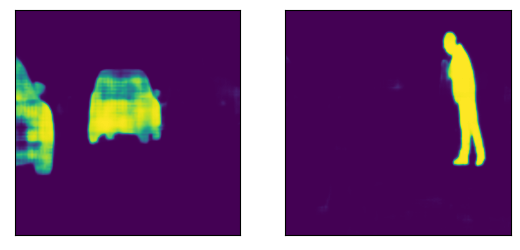

In [20]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)


car_person_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(images_list))
    for cls in ('car', 'person')
]
# car_person_masks = [  torch.tensor((mask > 0.5), dtype=torch.uint8) for mask in car_person_masks]

show(car_person_masks)

The :func:`~torchvision.utils.draw_segmentation_masks` function can be used to
plots those masks on top of the original image. This function expects the
masks to be boolean masks.


shape = torch.Size([1, 1000, 1000]), dtype = torch.bool


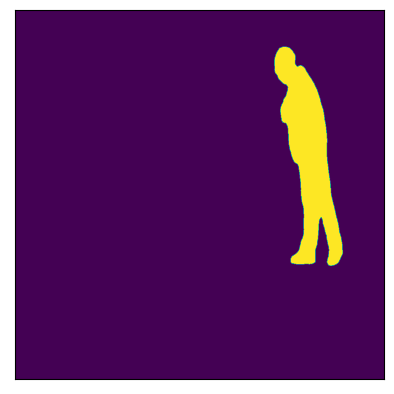

In [8]:
class_dim = 1
boolean_person_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['person'] )
print(f"shape = {boolean_person_masks.shape}, dtype = {boolean_person_masks.dtype}")
show([m.float() for m in boolean_person_masks])

In [9]:
print(weights.meta["categories"])

['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


we can use them with
:func:`~torchvision.utils.draw_segmentation_masks` to plot them on top of the
original images:



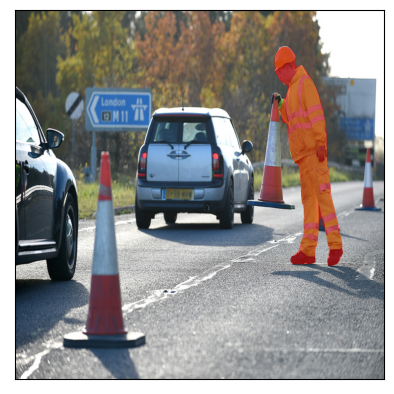

In [10]:
from torchvision.utils import draw_segmentation_masks
img_with_masks = [
    draw_segmentation_masks(img, masks=mask , colors = ['red'] , alpha=0.5)
    for img, mask in zip(images_list, boolean_person_masks )
]
show(img_with_masks)

shape = torch.Size([21, 1, 1000, 1000]), dtype = torch.bool


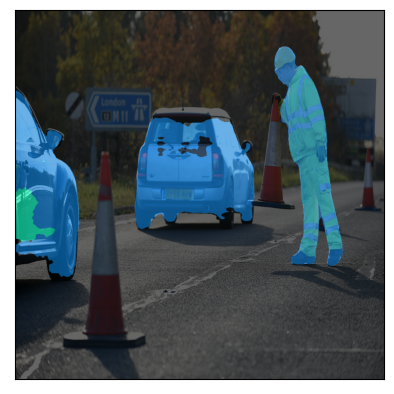

In [11]:
num_classes = normalized_masks.shape[1]
img_masks = normalized_masks[0]
class_dim = 1

all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

img_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(images_list, all_classes_masks)
]
show(img_with_masks)


### Instance segmentation models

here is an Instance segmentation model loaded from : `torchvision.models.detection.fasterrcnn_resnet50_fp`


In [12]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

# the input images normalized to [0, 1]
images = [transforms(d) for d in images_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)

For each image in the batch, the model outputs some
detections (or instances). The number of detections varies for each input
image. Each instance is described by its bounding box, its label, its score
and its mask.

In [13]:
img_output = output[0]
img_masks = img_output['masks']
print(f"shape = {img_masks.shape}, dtype = {img_masks.dtype}, "
      f"min = {img_masks.min()}, max = {img_masks.max()}")

shape = torch.Size([15, 1, 1000, 1000]), dtype = torch.float32, min = 0.0, max = 0.9999929666519165


Here the masks correspond to probabilities indicating, for each pixel, how
likely it is to belong to the predicted label of that instance. Those
predicted labels correspond to the 'labels' element in the same output dict.
Let's see which labels were predicted for the instances of the first image.



In [14]:
print("For the first img, the following instances were detected:")
print([weights.meta["categories"][label] for label in img_output['labels']])

For the first img, the following instances were detected:
['person', 'car', 'car', 'person', 'truck', 'stop sign', 'person', 'traffic light', 'truck', 'baseball bat', 'person', 'truck', 'person', 'person', 'car']


shape = torch.Size([15, 1, 1000, 1000]), dtype = torch.bool


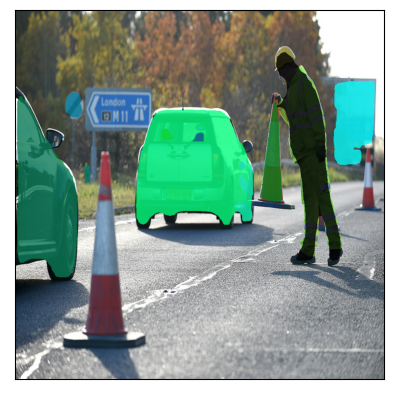

In [15]:
proba_threshold = 0.80
img_bool_masks = img_output['masks'] > proba_threshold
print(f"shape = {img_bool_masks.shape}, dtype = {img_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
img_bool_masks = img_bool_masks.squeeze(1)

show(draw_segmentation_masks(images_list[0], img_bool_masks , alpha=0.8))

The model seems to have properly detected the opject, but it also confused trees
with people. Looking more closely at the scores will help us plot more
relevant masks:



tensor([0.9988, 0.9811, 0.8256, 0.5641, 0.4190, 0.1962, 0.1678, 0.1312, 0.0895, 0.0894, 0.0870, 0.0806, 0.0573, 0.0570, 0.0565], grad_fn=<IndexBackward0>)


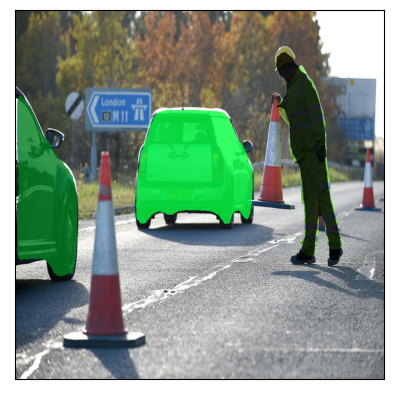

In [16]:
print(img_output['scores'])

score_threshold = 0.75

boolean_masks = [out['masks'][out['scores'] > score_threshold] > proba_threshold for out in output]

imgs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(images_list, boolean_masks)
]
show(imgs_with_masks)